**Author:** eeysirhc  
**Date written:** 2021-12-20  
**Last updated:** 2022-03-01  
**Objective:** visualize Ergo wallet distribution to find the average mean of all HODL-ers

## Load modules

In [52]:
import pandas as pd
pd.set_option('display.max_colwidth', 1000)

import matplotlib.pyplot as plt
#from pandas.plotting import register_matplotlib_converters
#register_matplotlib_converters()

import seaborn as sns

from sqlalchemy import create_engine

## Onboard data

In [58]:
POSTGRES_ADDRESS = address
POSTGRES_PORT = port
POSTGRES_USERNAME = username
POSTGRES_PASSWORD = password
POSTGRES_DBNAME = dbname

postgres_str = ('postgresql://{username}:{password}@{ipaddress}:{port}/{dbname}'.format(username=POSTGRES_USERNAME,password=POSTGRES_PASSWORD,ipaddress=POSTGRES_ADDRESS,port=POSTGRES_PORT,dbname=POSTGRES_DBNAME))

conn = create_engine(postgres_str)

qry = open('../../sql/ergo-address_balance.sql')
df_raw = pd.read_sql_query(qry.read(), conn)
qry.close()

## Process data

In [60]:
# sort by date
df = df_raw.sort_values('timestamp', ascending=True)

# calculate daily address amount
df['balance'] = df.groupby(['address'])['diff'].cumsum()

# grab most recent address balance total
df_final = df.groupby('address').tail(1)

# convert timestamp to DT format
df_final['timestamp'] = pd.to_datetime(df_final['timestamp'], utc=True)

/var/folders/2z/fz3wt0tn15bg83qdr608nct40000gn/T/ipykernel_10968/3688742189.py:13: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_final['timestamp'] = pd.to_datetime(df_final['timestamp'], utc=True)


## Wallet segmentation

In [68]:
# function to classify address balances
def wallet_classifier(balance):
    if balance <= 0.00:
        return 'exclude'
    elif balance <= 0.10:
        return 'dust'
    elif balance <= 1.00:
        return 'plankton'
    elif balance <= 10:
        return 'shrimp'
    elif balance <= 100: 
        return 'prawn'
    elif balance <= 1e3: 
        return 'crab'
    elif balance <= 5e3: 
        return 'lobster'
    elif balance <= 1e4: 
        return 'octopus'
    elif balance <= 1e5: 
        return 'fish'
    elif balance <= 5e5: 
        return 'dolphin'
    elif balance <= 1e6: 
        return 'shark'                                        
    else:
        return 'whale'

In [69]:
# Apply wallet classifier
df_final['segment'] = df_final['balance'].apply(wallet_classifier)

# Remove 0 balance wallets
df_final = df_final[df_final['segment'] != 'exclude']

## Plotting region

<Figure size 600x400 with 0 Axes>

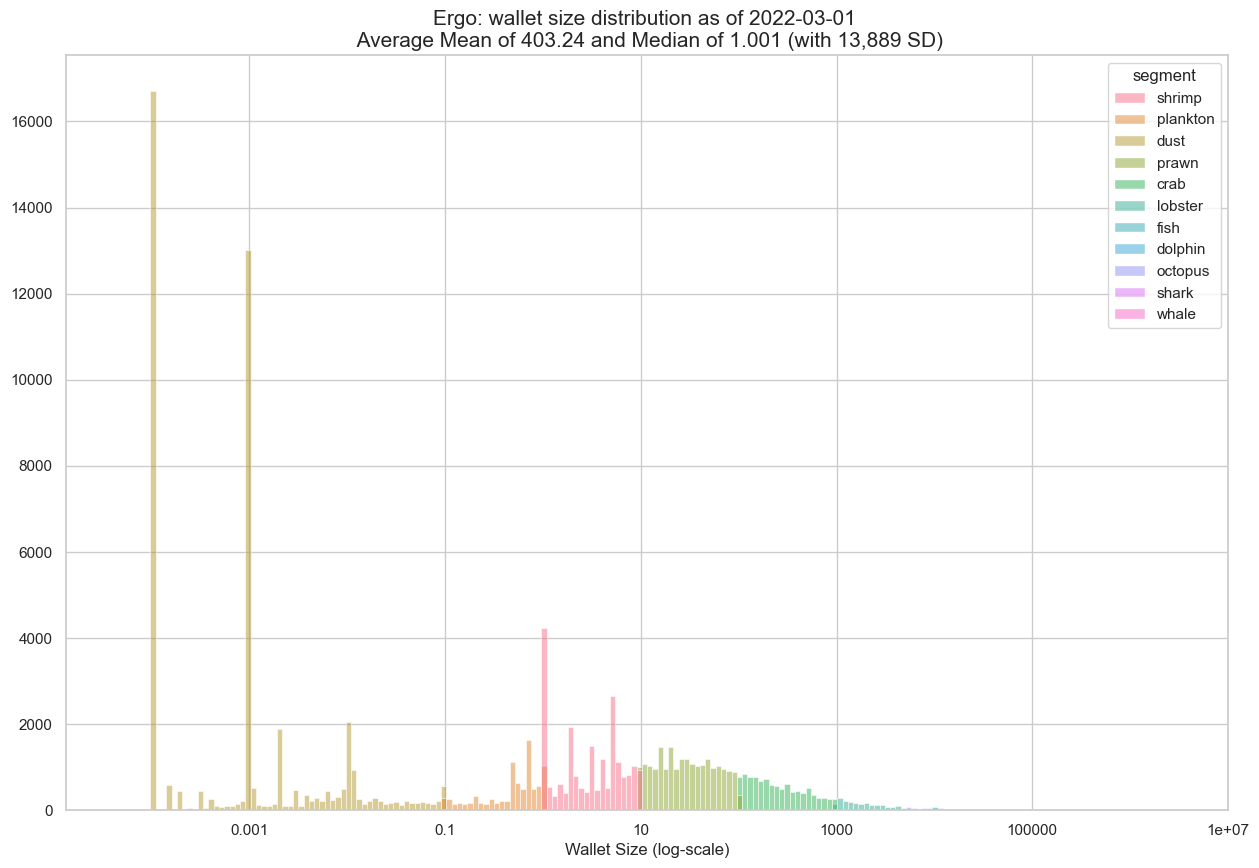

In [74]:
df_clean = df_final[df_final['balance'] > 0.000001]

import matplotlib.ticker as ticker

sns.set(style="whitegrid")
plt.rcParams["figure.dpi"] = 100

plt.clf()
plt.figure(figsize=(15,10))

ax = sns.histplot(data=df_clean, x='balance', hue='segment', bins=200, log_scale=True)
ax.xaxis.set_major_formatter(ticker.FuncFormatter(lambda x, _: '{:g}'.format(x)))

plt.title("Ergo: wallet size distribution as of 2022-03-01 \n Average Mean of 403.24 and Median of 1.001 (with 13,889 SD)", fontsize = 15)
plt.xlabel("Wallet Size (log-scale)")
plt.ylabel("")

plt.show()

## Statistics

In [75]:
avg_mean = df_clean.balance.mean()
avg_median = df_clean.balance.median()
avg_sd = df_clean.balance.std()

print("Mean: ", round(avg_mean, 2))
print("Median: ", round(avg_median, 5))
print("SD: ", round(avg_sd, 2))

Mean:  403.24
Median:  1.00062
SD:  13889.34
